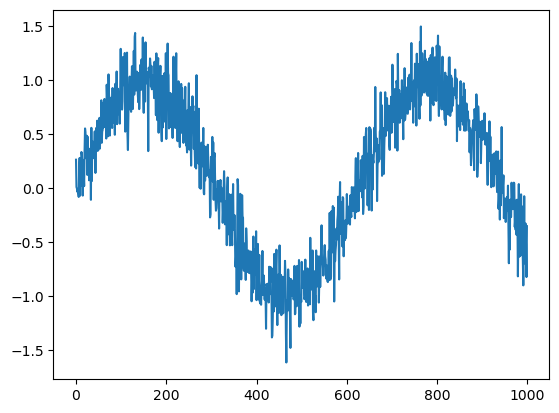

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import d2l
T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x= torch.sin(0.01*time) + torch.normal(0,0.2,(T,))
plt.plot(list(range(T)),x)

In [5]:
# 将这个序列转换为标签对
tau=4
features=torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels=x[tau:].reshape((-1,1))
batchSize=16
nTrain=600

tensor([[ 0.2635,  0.0105, -0.0023, -0.0334],
        [ 0.0105, -0.0023, -0.0334, -0.0118],
        [-0.0023, -0.0334, -0.0118, -0.0435],
        ...,
        [-0.0742, -0.6949, -0.4251, -0.3267],
        [-0.6949, -0.4251, -0.3267, -0.5244],
        [-0.4251, -0.3267, -0.5244, -0.8214]])


In [9]:
# nTrain进行训练
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator.

    Defined in :numref:`sec_utils`"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)
train_iter=load_array((features[:nTrain],labels[:nTrain]),batchSize,is_train=True)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net=nn.Sequential(nn.Linear(4,10),
    nn.ReLU(),nn.Linear(10,1))

    net.apply(init_weights)
    return net

loss=nn.MSELoss(reduction='none')

def train(net,train_iter,loss,epochs,lr):
    trainer=torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            # 每一轮的训练
            trainer.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(l)
net=get_net()
train(net,train_iter,loss,5,0.01)

tensor([[0.0074],
        [0.0010],
        [0.0152],
        [0.6088],
        [0.0926],
        [0.0156],
        [0.1433],
        [0.1377]], grad_fn=<MseLossBackward0>)
tensor([[1.3170e-01],
        [2.1963e-04],
        [8.4174e-02],
        [2.6708e-02],
        [1.5146e-02],
        [2.3435e-01],
        [3.0466e-02],
        [5.8184e-03]], grad_fn=<MseLossBackward0>)
tensor([[0.0432],
        [0.0002],
        [0.0351],
        [0.0087],
        [0.0139],
        [0.0011],
        [0.0228],
        [0.0070]], grad_fn=<MseLossBackward0>)
tensor([[5.8314e-02],
        [1.0623e-01],
        [2.9732e-02],
        [1.8825e-02],
        [8.7376e-04],
        [3.6761e-05],
        [1.4762e-02],
        [4.4387e-03]], grad_fn=<MseLossBackward0>)
tensor([[1.5256e-02],
        [9.6279e-02],
        [9.4139e-04],
        [7.5337e-02],
        [6.8523e-02],
        [8.7150e-05],
        [1.1117e-01],
        [7.3177e-04]], grad_fn=<MseLossBackward0>)


## RNN 学习

In [21]:
X=torch.normal(0,1,(1888,4))
W_xh=torch.normal(0,1,(4,128))
torch.matmul(X,W_xh)
H_pre=torch.normal(0,1,(1,128)) # hidden state
b=torch.normal(0,1,(1,128))
HH=torch.normal(0,1,(128,128))
torch.matmul(X,W_xh)+torch.matmul(H_pre,HH)+b

tensor([[ -4.0697, -23.3955,  17.1097,  ...,  12.3921,   8.7196,  11.7304],
        [ -0.2617, -23.1622,  13.8526,  ...,  13.1080,   9.3014,  12.4348],
        [-11.2710, -19.3200,  18.8682,  ...,  14.2013,  10.9674,  11.5419],
        ...,
        [ -2.9653, -14.4001,  10.2909,  ...,  15.3213,  12.6565,  11.3390],
        [ -9.4676, -10.5245,  11.3134,  ...,  17.3918,  14.8564,  12.3333],
        [ -7.7476, -12.4265,  11.1432,  ...,  17.3979,  14.8572,  11.6253]])

In [28]:
def get_params(vocab_size,num_hiddens,device):
    ''' 
    词元的大小设置

    这里的vocab size=1 (时间序列预测问题)
    '''
    num_inputs=num_outputs=vocab_size
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    
    # 隐藏层参数
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)

    # 输出层参数
    W_hq=normal((num_hiddens,num_outputs))
    b_q=torch.zeros(num_outputs,device=device)

    # 增加梯度
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state(batchSize,num_hiddens,device):
    ''' 
    初始化循环神经网络参数
    '''
    return (torch.zeros((batchSize,num_hiddens),device=device),)

def rnn(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q=params
    H,=state
    outputs=[]
    for X in inputs:
        H=torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
        Y=torch.mm(H,W_hq)+b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

# 类的方式包装RNNmodel
from torch.nn import functional as F

class RNNmodelScratch:
    def __init__(self,vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn=init_state,forward_fn
    
    def __call__(self,X,state):
        X=F.one_hot(X.T,self.vocab_size).type(torch.int64)
        return self.forward_fn(X,state,self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

num_hiddens = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RNNmodelScratch(1, num_hiddens, device, get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], device)
Y, new_state = net(X.to(device), state)
Y.shape, len(new_state), new_state[0].shape


RuntimeError: one_hot is only applicable to index tensor.